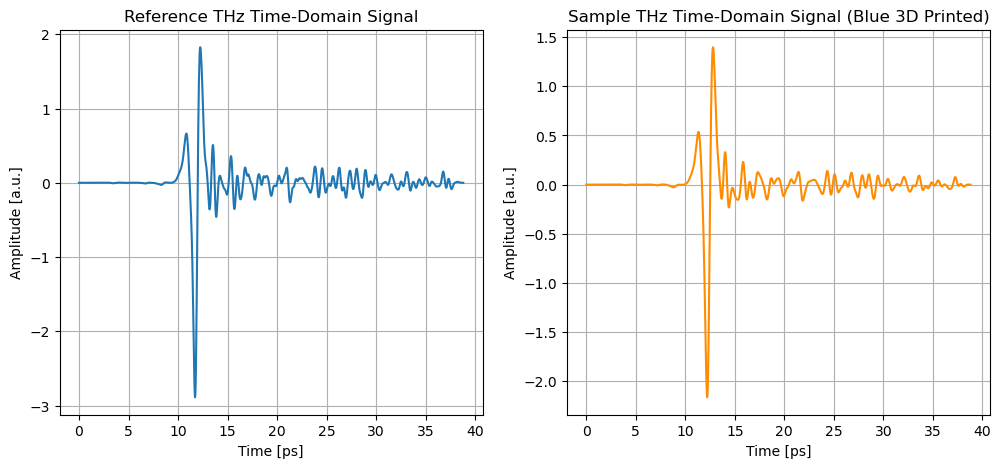

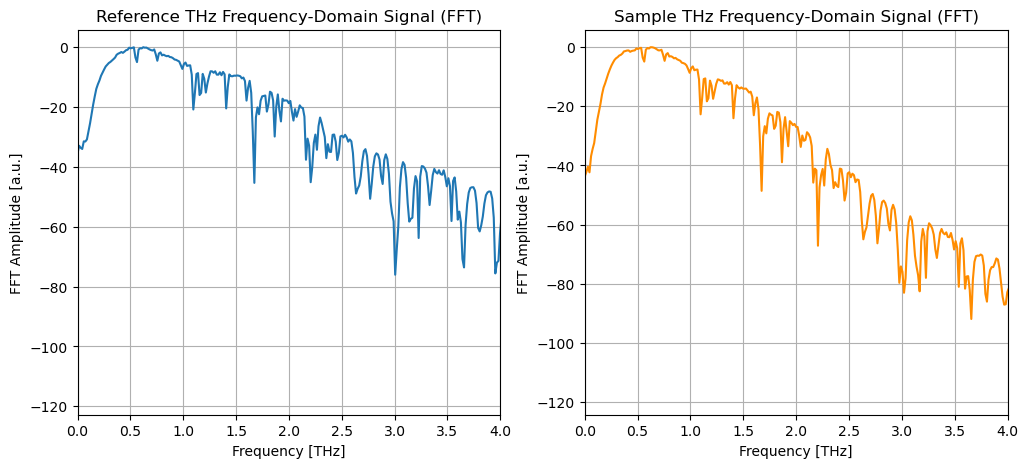

In [1]:
import numpy as np 
import matplotlib.pyplot as plt



# INSERT REFERENCE DATA 
reference_pulse = np.loadtxt(r"D:\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data\Ref2.txt",dtype=float)
reference_fft = np.loadtxt(r"D:\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data\Ref2_fft.txt",dtype=float)

# INSERT SAMPLE DATA
sample_pulse_black = np.loadtxt(r"D:\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data\Sample_black_3dprint.txt",dtype=float)
sample_pulse_black_fft = np.loadtxt(r"D:\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data\Sample_black_3dprint_fft.txt",dtype=float)

# PLOTTING REFERENCE AND SAMPLE SIGNALS

# REFERENCE
t1= reference_pulse[:,0] + 733.8  # ADJUISTING THE AXIS
ref_signal = reference_pulse[:,1]
f1 = reference_fft[:,0] + 0  # HERE, ADJUSTING THE AXIS IS NOT NECESSARY
fft_signal = reference_fft[:,1]

# SAMPLE
t2= sample_pulse_black[:,0] + 733.8  # ADJUISTING THE AXIS
sample_signal = sample_pulse_black[:,1]
f2 = sample_pulse_black_fft[:,0] + 0 # HERE, ADJUSTING THE AXIS IS NOT NECESSARY
sample_fft_signal = sample_pulse_black_fft[:,1]

# PLOTS
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(t1,ref_signal)
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Reference THz Time-Domain Signal')
plt.grid()  
plt.subplot(1,2,2)
plt.plot(t2,sample_signal, color='darkorange')
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Sample THz Time-Domain Signal (Blue 3D Printed)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(f1,fft_signal)
plt.xlim(0,4)
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Reference THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.subplot(1,2,2)
plt.plot(f2,sample_fft_signal, color='darkorange')
plt.xlim(0,4)
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Sample THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.show()


Time delay (ps):  0.5608843499999239
Average refractive index:  1.8413265249998858


C:\Users\theod\AppData\Local\Temp\ipykernel_15864\3096435031.py:31: RuntimeWarning: invalid value encountered in divide
  transfer_signal = sample_fft_signal / fft_signal
C:\Users\theod\AppData\Local\Temp\ipykernel_15864\3096435031.py:44: RuntimeWarning: invalid value encountered in scalar divide
  ln_th =(np.log((4 * n_0 * n) / (n_0 + n)**2)
C:\Users\theod\AppData\Local\Temp\ipykernel_15864\3096435031.py:44: RuntimeWarning: invalid value encountered in log
  ln_th =(np.log((4 * n_0 * n) / (n_0 + n)**2)
C:\Users\theod\AppData\Local\Temp\ipykernel_15864\3096435031.py:49: RuntimeWarning: invalid value encountered in scalar divide
  p = 1 / n
C:\Users\theod\AppData\Local\Temp\ipykernel_15864\3096435031.py:50: RuntimeWarning: invalid value encountered in scalar divide
  m = 2 / (n + n_0) + (1j * 2 * np.pi* f * d) / c
C:\Users\theod\AppData\Local\Temp\ipykernel_15864\3096435031.py:58: RuntimeWarning: invalid value encountered in scalar divide
  dn = G_zero_ / G_zerod_
C:\Users\theod\AppData

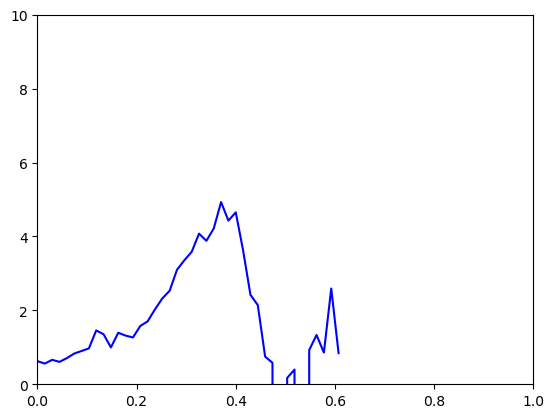

In [2]:
# PHASE UNWRAPPING 
uwrapped_ref = np.unwrap(np.angle(fft_signal))
uwrapped_sample = np.unwrap(np.angle(sample_fft_signal))
delta = uwrapped_sample - uwrapped_ref


# TIME DELAY BETWEEN SIGNALS CALCULATION

max_reference_signal = np.max(ref_signal)
point_in_time_ref = t1[ref_signal.argmax()]
max_sample_signal = np.max(sample_signal)
point_in_time_sample = t2[sample_signal.argmax()]

dt =   (point_in_time_sample) -  (point_in_time_ref)  #time delay in ps
print("Time delay (ps): ", dt)


# REFRACTIVE INDEX CALCULATION

f2[f2 == 0] = 1e-12  # Replace zeros with a small value to avoid division by zero
c = 3e8 #speed of light in m/s
d = 0.0002 #thickness of sample in m
n_0 = 1  # Refractive index of air

navg = 1 + (c * dt*1e-12) / d
print("Average refractive index: ", navg)


# TRANSFER FUNCTION CALCULATION

transfer_signal = sample_fft_signal / fft_signal
transfer_phase = np.angle(transfer_signal)
tphase_unwrapped = np.unwrap(transfer_phase)
ln_transfer = np.log(np.abs(transfer_signal) + 1e-12) + 1j * tphase_unwrapped

f_hz = f2 * 1e12  # Convert THz to Hz
frequency = f_hz > 1e-12  # Exclude zero frequency

refractive = 1 + (np.abs(delta)* c) / (2 * np.pi * f2*10e12 * d)

# NEWTON RAPHSON METHOD
def G_zero(n, f, ln_exp):

    ln_th =(np.log((4 * n_0 * n) / (n_0 + n)**2)
             -(1j * 2 * np.pi * f * d / c) * (n - n_0))
    return  ln_th - ln_exp

def G_zerod(n, f):
    p = 1 / n
    m = 2 / (n + n_0) + (1j * 2 * np.pi* f * d) / c 
    return p - m 

def new_raph(n_1, ln_exp, f, iterations, tol):
    n = n_1
    for i in range(iterations): 
        G_zero_ = G_zero(n,  f, ln_exp)
        G_zerod_ = G_zerod(n, f)
        dn = G_zero_ / G_zerod_
        n = n - dn
        if abs(G_zero_/G_zerod_) < tol:
           # print(i, "iterations")
            break
    return n


# INITIAL GUESS AND CALCULATION
n_1 = 1.7 + 0.05j
n_ = []

for i, f in enumerate(frequency, 0):
    ln_exp = ln_transfer[i] + 1j * tphase_unwrapped[i]
    n_values = new_raph( n_1 ,ln_exp, f,  iterations=50, tol=1e-10)
    n_.append(n_values)


# print("Refractive index values:", n_)
n_ = np.array(n_) 

# PLOTTING REFRACTIVE INDEX

plt.plot(f2, n_.real, label='Refractive Index (n)', color='blue')
plt.xlim(xmax = 1, xmin = 0)
plt.ylim(ymax = 10, ymin = 0)
plt.show()

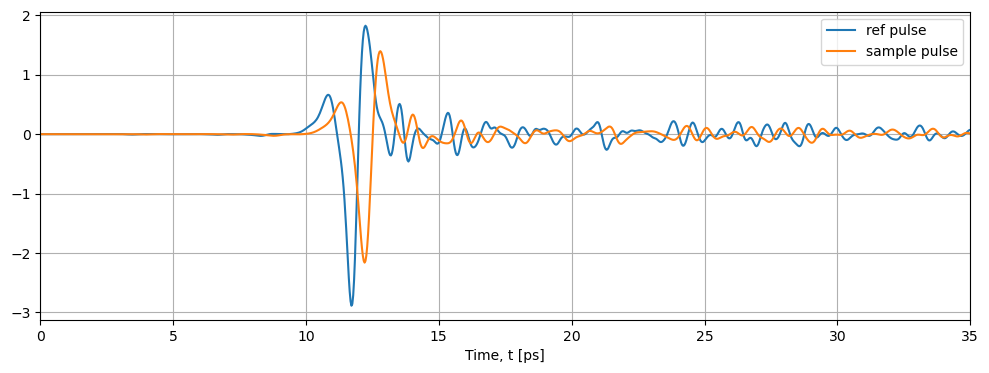

In [3]:
import torch
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.Simulate import simulate_parallel

# BAYES AND ADAM EXTRACTION

# CONVERT DATA TO TENSORS

# REFERENCE PULSE
reference_pulse_tensor = torch.tensor(ref_signal, dtype=torch.float32)
#SAMPLE PULSE
sample_pulse_tensor = torch.tensor(sample_signal, dtype=torch.float32)


plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(),label='ref pulse')
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),label='sample pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.xlim(0,35)
plt.grid()
plt.show()

Delta t:  0.03299319999996442
Number of time points, L:  1177
Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.39, 1.99)
Layer 1 - k ∈ (-0.0115, 0.0085)
Layer 1 - D ∈ (0.00018, 0.00022)
[((1.8679257921161398-0.007831304202676723j), 0.0002111876400109108)]


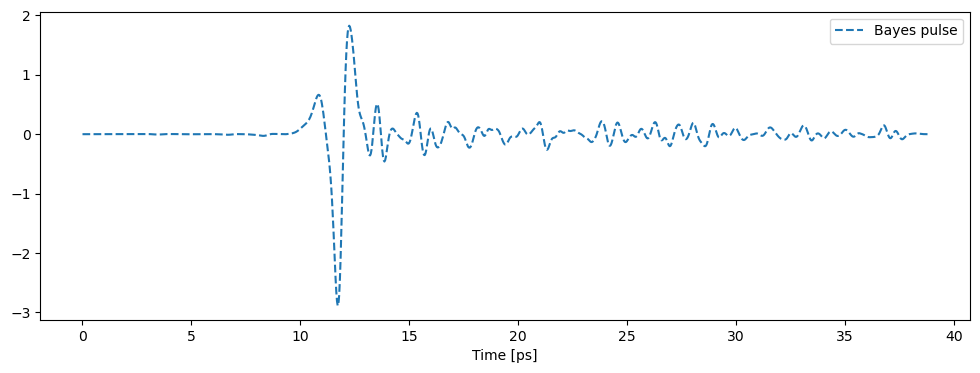

Fine-tuning 3 parameters for 300 iterations.
Iteration 49, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00783, D=211.19 µm
Iteration 99, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00783, D=211.19 µm
Iteration 149, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00783, D=211.19 µm
Iteration 199, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00783, D=211.19 µm
Iteration 249, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00784, D=211.19 µm
Iteration 299, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00784, D=211.19 µm
[((1.867925763130188-0.007831322029232979j), 0.0002111875801347196)]


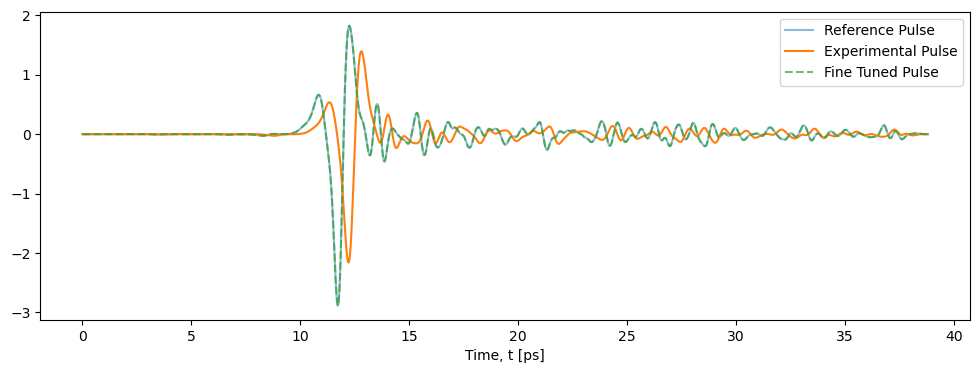

In [4]:
# set initial guesses for Bayes optimization
layers_init = [(1.69-0.0015j, 2e-4)]
optimization_bounds = [0.3, 0.01, 2e-5]
deltat = t1[1] - t1[0]
L = reference_pulse_tensor.shape[0]
print("Delta t: ", deltat)
print("Number of time points, L: ", L)

# Set optimization mask
optimization_mask = [(True, True, True)]

# Initialize extractor for the data
Bayes_extractor = BayesianLayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, layers_init,optimization_mask, optimization_bounds=optimization_bounds)

# Run the extraction loop and returns parameters
bayes_params = ms = Bayes_extractor.bayesian_optimization(n_calls=50)




# Run forward pass with Jeff’s model
bayes_pulse = simulate_parallel(reference_pulse_tensor,bayes_params, deltat, 0)[1].detach().cpu().numpy()[:L]
 # Print the parameters
print(bayes_params)
 # plot the pulse
plt.figure(figsize=(12,4))
plt.plot(t1, bayes_pulse, label='Bayes pulse', linestyle='--')
plt.xlabel('Time [ps]')
#plt.xlim([1655, 1675])
plt.legend()
plt.show()







 # Initialize adam optimizer object
grad_optimizer = LayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, bayes_params,optimization_mask, lr=0.0001)
 # Run optimization for set iterations, ‘updates’ provides a printout of progress
optim_params = grad_optimizer.optimize(num_iterations=300,updates=50)
optim_pulse = simulate_parallel(reference_pulse_tensor,
optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]
print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(), label='Reference Pulse',
alpha=0.5)
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),
label='Experimental Pulse')
plt.plot(t1, optim_pulse, label='Fine Tuned Pulse',alpha=0.7, linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend() 
plt.show()

Fine-tuning 3 parameters for 300 iterations.
Iteration 49, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00783, D=211.19 µm
Iteration 99, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00783, D=211.19 µm
Iteration 149, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00783, D=211.19 µm
Iteration 199, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00783, D=211.19 µm
Iteration 249, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00784, D=211.19 µm
Iteration 299, Loss: 4.795343e-01, Layer 0: n=1.8679, k=-0.00784, D=211.19 µm
[((1.867925763130188-0.007831322029232979j), 0.0002111875801347196)]


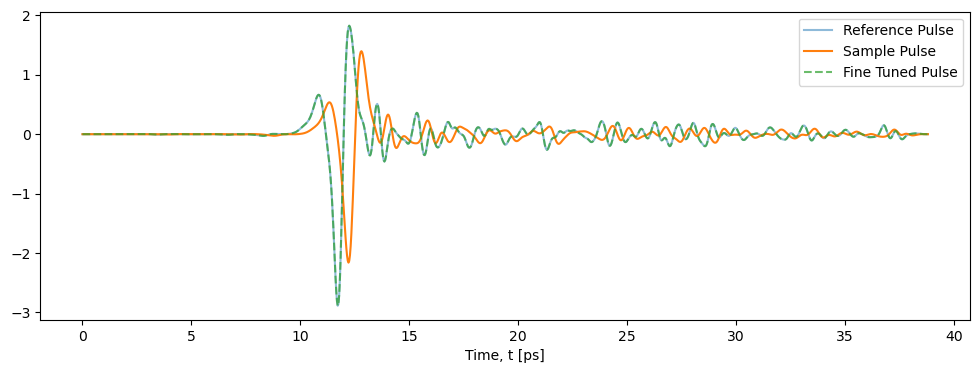

In [5]:
 # Initialize adam optimizer object
grad_optimizer = LayeredExtractor(reference_pulse_tensor,
 sample_pulse_tensor, deltat, bayes_params,
 optimization_mask, lr=0.0001)
 # Run optimization for set iterations, ‘updates’ provides a printout of progress

optim_params = grad_optimizer.optimize(num_iterations=300,updates=50)
optim_pulse = simulate_parallel(reference_pulse_tensor,optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]
print(optim_params)


plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(), label='Reference Pulse',
 alpha=0.5)
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),
label='Sample Pulse')
plt.plot(t2, optim_pulse, label='Fine Tuned Pulse',alpha=0.7, linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [6]:
print("The final parameters given by the extraction are:")
print(optim_params)

The final parameters given by the extraction are:
[((1.867925763130188-0.007831322029232979j), 0.0002111875801347196)]
